In [230]:
import sqlite3

import os
import re

import numpy as np
# It is apparently officially accepted to explicitly
# list all the functions you need from numpy:
from numpy import array, zeros, exp, random, dot
from numpy import shape, reshape, meshgrid, linspace
from numpy import hstack, vstack

import pandas as pd
print('Panda Version:', pd.__version__)

# Set ipython's max row display
pd.set_option('display.max_row', 100, 'display.max_columns', 25)

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100 # highres display

import tensorflow as tf
from tensorflow import Variable

from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed, RepeatVector

from keras.optimizers import SGD

from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.layers import LSTM, Dense, Concatenate

from keras.optimizers import SGD

import collections
from collections import Counter

import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import date class from datetime module
import time
import datetime
# import datetime as dt
from datetime import date
print("Today date is: ", date.today())

Panda Version: 2.2.2
Today date is:  2024-06-14


In [165]:
!pwd

!ls -la /workspace/data/crypto_md/

/workspace/leo
total 16400
drwxrwxr-x 1 1000 1000     648 Jun 13 10:01 .
drwxrwxr-x 1 1000 1000      18 Jun  3 23:40 ..
-rw------- 1 1000 1000 1449984 Jun  4 00:49 20240601.mktdata.ohlcv.db
-rw------- 1 1000 1000 1445888 Jun  3 23:44 20240602.mktdata.ohlcv.db
-rw------- 1 1000 1000 1437696 Jun  4 16:45 20240603.mktdata.ohlcv.db
-rw------- 1 1000 1000 1269760 Jun  5 10:00 20240604.mktdata.ohlcv.db
-rw------- 1 1000 1000 1081344 Jun  6 10:00 20240605.mktdata.ohlcv.db
-rw------- 1 1000 1000 1441792 Jun  7 10:00 20240606.mktdata.ohlcv.db
-rw------- 1 1000 1000 1445888 Jun  8 10:00 20240607.mktdata.ohlcv.db
-rw------- 1 1000 1000 1449984 Jun  9 10:00 20240608.mktdata.ohlcv.db
-rw------- 1 1000 1000 1437696 Jun 10 10:00 20240609.mktdata.ohlcv.db
-rw-r--r-- 1 1000 1000       0 Jun 12 15:29 20240609.mktdata.ohlcvdb
-rw------- 1 1000 1000 1437696 Jun 11 10:00 20240610.mktdata.ohlcv.db
-rw------- 1 1000 1000 1449984 Jun 12 10:01 20240611.mktdata.ohlcv.db
-rw------- 1 1000 1000 1445888 Jun 13 10:

In [82]:
# db_conn = sqlite3.connect(mktdata_db_file)
# tables_df = pd.read_sql_query("select * from sqlite_master where type = 'table'", db_conn)
# print (tables_df_20240601.head())

In [167]:
directory = "/workspace/data/crypto_md"

# List of dates
dates = ['20240601', 
         '20240602', 
         '20240603', 
         '20240604', 
         '20240605', 
         '20240606', 
         '20240607', 
         '20240608', 
         '20240609',
         '20240610',
         '20240611',
         '20240612']        

# Create an entirely empty DataFrame
df_concat = pd.DataFrame()

for date in dates:
    # Construct the filename
    filename = f"{directory}/{date}.mktdata.ohlcv.db"
    
    # Create the SQLite connection
    conn = sqlite3.connect(filename)
    
    # Read the data into a DataFrame
    df = pd.read_sql_query("select * from coinbase_ohlcv_1min", conn)

    df_concat = pd.concat([df_concat, df], axis = 0,ignore_index = True)
    # Print the combined DataFrame
    # print(df_concat.shape[0])
    # print(df_concat.shape[1])
    conn.close()
print(df_concat.shape[0])
# print(df_concat.head(2))
# print(df_concat.tail(2))

66803


In [174]:
df_concat['tstamp'] = pd.to_datetime(df_concat['tstamp'])
# Extract individual components
df_concat['year'] = df_concat['tstamp'].dt.year
df_concat['month'] = df_concat['tstamp'].dt.month
df_concat['day'] = df_concat['tstamp'].dt.day
df_concat['hour'] = df_concat['tstamp'].dt.hour
df_concat['minute'] = df_concat['tstamp'].dt.minute
df_concat['second'] = df_concat['tstamp'].dt.second

df_concat['date'] = df_concat['day'].astype(str) + '-' + df_concat['hour'].astype(str) + '-' + df_concat['minute'].astype(str)
df_concat = df_concat.sort_values(by = ['day', 'hour', 'minute'])

selected_columns = ['date', 'instrument_id', 'close', 'volume', 'vwap']
df_concat = df_concat[selected_columns]

# instrument_list = df_concat['instrument_id'].unique().tolist()
# print("Distinct values in column 'instrument_id':", instrument_list)



In [179]:
# BTC
df_concat_btc = df_concat[df_concat['instrument_id'] == 'PAIR-BTC-USD']

# Reset Index
df_concat_btc = df_concat_btc.reset_index(drop = True)

# Rename Vars
df_concat_btc['close_btc'] = df_concat_btc['close']/100000.00
df_concat_btc['volume_btc'] = df_concat_btc['volume']
df_concat_btc['vwap_btc'] = df_concat_btc['vwap']/100000.00

df_concat_btc = df_concat_btc.drop('close', axis = 1)
df_concat_btc = df_concat_btc.drop('volume', axis = 1)
df_concat_btc = df_concat_btc.drop('vwap', axis = 1)
df_concat_btc = df_concat_btc.drop('instrument_id', axis = 1)

# print (df_concat_btc.head(3))

# LTC
df_concat_ltc = df_concat[df_concat['instrument_id'] == 'PAIR-LTC-USD']

# Reset Index
df_concat_ltc = df_concat_ltc.reset_index(drop = True)

# Rename Vars
df_concat_ltc['close_ltc'] = df_concat_ltc['close']/100.00
df_concat_ltc['volume_ltc'] = df_concat_ltc['volume']
df_concat_ltc['vwap_ltc'] = df_concat_ltc['vwap']/100.00

df_concat_ltc = df_concat_ltc.drop('close', axis = 1)
df_concat_ltc = df_concat_ltc.drop('volume', axis = 1)
df_concat_ltc = df_concat_ltc.drop('vwap', axis = 1)
df_concat_ltc = df_concat_ltc.drop('instrument_id', axis = 1)

# print (df_concat_ltc.head(3))

# ETH
df_concat_eth = df_concat[df_concat['instrument_id'] == 'PAIR-ETH-USD']

# Reset Index
df_concat_eth = df_concat_eth.reset_index(drop = True)

# Rename Vars
df_concat_eth['close_eth'] = df_concat_eth['close']/10000.00
df_concat_eth['volume_eth'] = df_concat_eth['volume']
df_concat_eth['vwap_eth'] = df_concat_eth['vwap']/10000.00

df_concat_eth = df_concat_eth.drop('close', axis = 1)
df_concat_eth = df_concat_eth.drop('volume', axis = 1)
df_concat_eth = df_concat_eth.drop('vwap', axis = 1)
df_concat_eth = df_concat_eth.drop('instrument_id', axis = 1)

# print (df_concat_eth.head(3))

# XRP
df_concat_xrp = df_concat[df_concat['instrument_id'] == 'PAIR-XRP-USD']

# Reset Index
df_concat_xrp = df_concat_xrp.reset_index(drop = True)

# Rename Vars
df_concat_xrp['close_xrp'] = df_concat_xrp['close']
df_concat_xrp['volume_xrp'] = df_concat_xrp['volume']
df_concat_xrp['vwap_xrp'] = df_concat_xrp['vwap']

df_concat_xrp = df_concat_xrp.drop('close', axis = 1)
df_concat_xrp = df_concat_xrp.drop('volume', axis = 1)
df_concat_xrp = df_concat_xrp.drop('vwap', axis = 1)
df_concat_xrp = df_concat_xrp.drop('instrument_id', axis = 1)

# print (df_concat_xrp.head(3))

df_M1 = pd.merge(df_concat_xrp, df_concat_eth, on = 'date', how = 'outer')
# print (df_M1.head(3))
# print ("M1:  ", df_M1.shape[0])
df_M2 = pd.merge(df_M1, df_concat_ltc, on = 'date', how = 'outer')
# print (df_M2.head(3))
# print ("M2:  ", df_M2.shape[0])
df_M3 = pd.merge(df_M2, df_concat_btc, on = 'date', how = 'outer')
# print (df_M3.head(3))
# print ("M3:  ", df_M3.shape[0])

# Drop rows with any NaN value and assign it to a new DataFrame
# sample = df_M3.dropna(axis = 0).reset_index(drop = True)
print ("========================================")
print (sample.head(3))
sample_size = sample.shape[0]
print ("test sample size: ", sample_size)

     date  close_xrp    volume_xrp  vwap_xrp  close_eth  volume_eth  vwap_eth  \
0   1-0-0     0.5173  28809.165339  0.517217   0.376204   37.497964  0.376108   
1   1-0-1     0.5170  10184.511212  0.517060   0.375942   11.703305  0.376013   
2  1-0-10     0.5176  15515.348778  0.517601   0.375938   11.922897  0.375935   

   close_ltc  volume_ltc  vwap_ltc  close_btc  volume_btc  vwap_btc  
0     0.8317  110.056253  0.831662   0.675060    2.045049  0.674969  
1     0.8312  176.868598  0.831441   0.674947    0.646759  0.675009  
2     0.8311   58.951033  0.831037   0.675507    1.201335  0.675478  
test sample size:  16698


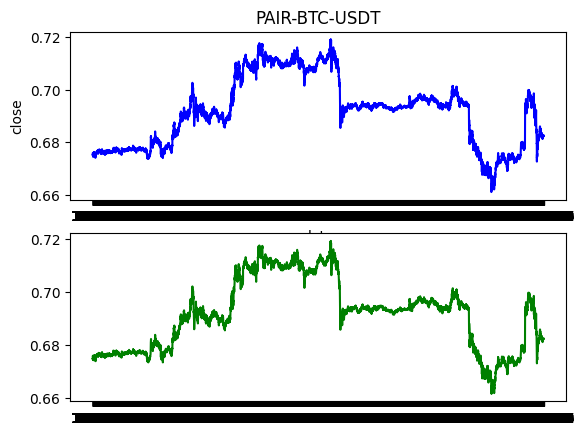

In [177]:
# Create a figure and axis object
fig, ax = plt.subplots(2 , 1)

# Plot the data
ax[0].plot(df_concat_btc['date'], df_concat_btc['close_btc'], 'blue')
# ax[0].plot(df_concat_btc['date'], df_concat_btc['vwap_btc'], 'green')

# Customize the plot
ax[0].set_title('PAIR-BTC-USDT')
ax[0].set_xlabel('date')
ax[0].set_ylabel('close')

ax[1].plot(df_concat_btc['date'], df_concat_btc['vwap_btc'], 'green')
# ax[1].plot(df_concat_btc['date'], df_concat_btc['volume_BTC'], 'red')

# Show the plot
plt.show()

In [180]:
split_index = round(sample.shape[0] * 0.8)

# First part of the DataFrame
sample_test = sample.iloc[:split_index]

# Second part of the DataFrame
sample_valid = sample.iloc[split_index:]

print("\nFirst part of the DataFrame:")
print (sample_test.tail(2))

print("\nSecond part of the DataFrame:")
print (sample_valid.head(2))


First part of the DataFrame:
          date  close_xrp    volume_xrp  vwap_xrp  close_eth  volume_eth  \
13356  7-23-25     0.4995   8673.755143  0.499557   0.368412   53.830657   
13357  7-23-26     0.4996  34403.036949  0.499605   0.368370   89.163024   

       vwap_eth  close_ltc  volume_ltc  vwap_ltc  close_btc  volume_btc  \
13356  0.368548     0.8003   74.882298  0.800537    0.69375    1.598973   
13357  0.368411     0.8002   30.666566  0.800233    0.69381    1.612419   

       vwap_btc  
13356  0.693999  
13357  0.693838  

Second part of the DataFrame:
          date  close_xrp    volume_xrp  vwap_xrp  close_eth  volume_eth  \
13358  7-23-27     0.4995   8240.166990  0.499561   0.368369  108.118487   
13359  7-23-28     0.4995  21256.045405  0.499585   0.367813  229.373936   

       vwap_eth  close_ltc  volume_ltc  vwap_ltc  close_btc  volume_btc  \
13358  0.368353     0.8002   43.931145  0.800134   0.693709    1.765308   
13359  0.368127     0.8002   22.408370  0.800188   

In [240]:
#  06.14.2024
# ============================
sample_size = sample_test.shape[0]
print ('sample_size: ', sample_size)

sl = 16  # <--- sequence length
batch = 1  # <--- batch size
n_features = 8 # <---- no. of variables
n_out = 1 # <----- no. of predicted variables
frwd = 1  # <--- how many to predict


# Trimming Indices !!!
# Marking selected rows
sample_test['Selected'] = 0

# Selecting m random rows without replacement
np.random.seed(125)
selected_indices = np.random.choice(sample_test.index, size = batch, replace = False)

sample_test.loc[selected_indices, 'Selected'] = 1 # print (sample_test[sample_test['Selected'] == 1])
chosen_idx1 = sample_test[sample_test['Selected'] == 1].index
chosen_idx2 = chosen_idx1[chosen_idx1 > sl]

thrown_idx1 = chosen_idx1[chosen_idx1 <= sl]
cnt_thrown_idx1 = len(thrown_idx1)

chosen_idx3 = chosen_idx2[chosen_idx2 < (sample_size - frwd)]

thrown_idx2 = chosen_idx2[chosen_idx2 >= (sample_size - frwd)]
cnt_thrown_idx2 = len(thrown_idx2)

cnt_thrown_idx = cnt_thrown_idx1 + cnt_thrown_idx2

print (selected_indices)

all_ts_xrp = np.empty((1, )) # final input/output
all_ts_eth = np.empty((1, )) # final input/output
all_ts_ltc = np.empty((1, )) # final input/output
all_ts_btc = np.empty((1, )) # final input/output

stdev_xrp =  np.empty((1, )) # final input/output
stdev_eth =  np.empty((1, )) # final input/output
stdev_ltc =  np.empty((1, )) # final input/output
stdev_btc =  np.empty((1, )) # final input/output

aft_ts_xrp = np.empty((1))
aft_ts_eth = np.empty((1))
aft_ts_ltc = np.empty((1))
aft_ts_btc = np.empty((1))

for idx in chosen_idx3:
  selected_rows_before = sample_test.iloc[max(0, idx-sl): idx]
  selected_rows_after = sample_test.iloc[max(0, idx): idx+frwd]

  # print ('====================')
  sr_before_vwap_xrp = np.array(selected_rows_before['vwap_xrp'])
  sr_after_vwap_xrp = np.array(selected_rows_after['vwap_xrp'])    
  # print (sr_before_vwap_xrp)

# Compute standard deviation
  std_dev_xrp = np.std(sr_before_vwap_xrp)
  std_dev_xrp_arr = np.repeat(std_dev_xrp, sl)
  # print(std_dev_xrp_arr)

  sr_before_vwap_eth = np.array(selected_rows_before['vwap_eth'])
  sr_after_vwap_eth = np.array(selected_rows_after['vwap_eth'])

# Compute standard deviation
  std_dev_eth = np.std(sr_before_vwap_eth)
  std_dev_eth_arr = np.repeat(std_dev_eth, sl)
  # print(std_dev_eth_arr)
    

  sr_before_vwap_ltc = np.array(selected_rows_before['vwap_ltc'])
  sr_after_vwap_ltc = np.array(selected_rows_after['vwap_ltc'])

# Compute standard deviation
  std_dev_ltc = np.std(sr_before_vwap_ltc)
  std_dev_ltc_arr = np.repeat(std_dev_ltc, sl)
  # print(std_dev_ltc_arr)
    
  sr_before_vwap_btc = np.array(selected_rows_before['vwap_btc'])
  sr_after_vwap_btc = np.array(selected_rows_after['vwap_btc'])

# Compute standard deviation
  std_dev_btc = np.std(sr_before_vwap_btc)
  std_dev_btc_arr = np.repeat(std_dev_btc, sl)
  # print(std_dev_btc_arr)
    
  all_ts_xrp = np.concatenate((all_ts_xrp, sr_before_vwap_xrp))
  stdev_xrp = np.concatenate((stdev_xrp, std_dev_xrp_arr))
    
  all_ts_eth = np.concatenate((all_ts_eth, sr_before_vwap_eth))
  stdev_eth = np.concatenate((stdev_eth, std_dev_eth_arr))

  all_ts_ltc = np.concatenate((all_ts_ltc, sr_before_vwap_ltc))
  stdev_ltc = np.concatenate((stdev_ltc, std_dev_ltc_arr))

  all_ts_btc = np.concatenate((all_ts_btc, sr_before_vwap_btc))
  stdev_btc = np.concatenate((stdev_btc, std_dev_btc_arr))

  aft_ts_xrp = np.concatenate((aft_ts_xrp, sr_after_vwap_xrp))
  aft_ts_eth = np.concatenate((aft_ts_eth, sr_after_vwap_eth))
  aft_ts_ltc = np.concatenate((aft_ts_ltc, sr_after_vwap_ltc))
  aft_ts_btc = np.concatenate((aft_ts_btc, sr_after_vwap_btc))

X_XRP = all_ts_xrp[1:]
X_XRP_stdev = stdev_xrp[1:]

X_ETH = all_ts_eth[1:]
X_ETH_stdev = stdev_eth[1:]

X_LTC = all_ts_ltc[1:]
X_LTC_stdev = stdev_ltc[1:]

X_BTC = all_ts_btc[1:]
X_BTC_stdev = stdev_btc[1:]

X0 = np.column_stack((X_XRP, X_XRP_stdev, X_ETH, X_ETH_stdev, X_LTC, X_LTC_stdev, X_BTC, X_BTC_stdev))
print (X0)

# ======== Model Input =========
X = X0.reshape(batch-cnt_thrown_idx, sl, n_features)
print ('XXXX ====== Actual Input ====== XXXX')
print (X.shape)

y_XRP = aft_ts_xrp[1:]
y_ETH = aft_ts_eth[1:]
y_LTC = aft_ts_ltc[1:]
y_BTC = aft_ts_btc[1:]

y = np.column_stack((y_XRP, y_ETH, y_LTC, y_BTC))
print (y)

y = y_BTC.reshape(batch-cnt_thrown_idx, frwd, n_out)
# print ('YYYY ====== Actual Input ====== YYYY')
print (y.shape)

sample_size:  13358
[1108]
[[5.18409007e-01 1.74656457e-04 3.76978106e-01 1.87974873e-04
  8.30976720e-01 4.13691462e-04 6.76322893e-01 1.69435655e-04]
 [5.18281600e-01 1.74656457e-04 3.76891560e-01 1.87974873e-04
  8.30856335e-01 4.13691462e-04 6.76295204e-01 1.69435655e-04]
 [5.18160992e-01 1.74656457e-04 3.76894853e-01 1.87974873e-04
  8.31396694e-01 4.13691462e-04 6.76243830e-01 1.69435655e-04]
 [5.18395710e-01 1.74656457e-04 3.77093334e-01 1.87974873e-04
  8.31512839e-01 4.13691462e-04 6.76356022e-01 1.69435655e-04]
 [5.18466873e-01 1.74656457e-04 3.77115186e-01 1.87974873e-04
  8.31656507e-01 4.13691462e-04 6.76334315e-01 1.69435655e-04]
 [5.18169063e-01 1.74656457e-04 3.77119085e-01 1.87974873e-04
  8.31606805e-01 4.13691462e-04 6.76275342e-01 1.69435655e-04]
 [5.18300186e-01 1.74656457e-04 3.77137593e-01 1.87974873e-04
  8.31608277e-01 4.13691462e-04 6.76244964e-01 1.69435655e-04]
 [5.18213605e-01 1.74656457e-04 3.77114097e-01 1.87974873e-04
  8.31657508e-01 4.13691462e-04 6.76

/tmp/ipykernel_28/3826110232.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_test['Selected'] = 0


In [253]:
# Figure AutoCorrelations and Partial AutoCorrelations
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from sklearn.preprocessing import MinMaxScaler

for i in range(batch-cnt_thrown_idx):
# Plot the autocorrelation function (ACF)    
    plt.figure(figsize = (12, 6))
    plot_acf(values[i], lags = sl - 1)
    plt.title('Autocorrelation Function (ACF)')
    plt.show()
    
# Plot the partial autocorrelation function (PACF)
    # plt.figure(figsize = (12, 6))
    # plot_pacf(values[round(i/2)], lags = 60)
    # plt.title('Partial Autocorrelation Function (PACF)')
    # plt.show()

NameError: name 'values' is not defined

<Figure size 1200x600 with 0 Axes>

In [242]:
print ("===================================================")
print ("sequence length:  ", sl)
print ("batch size:  ", batch-cnt_thrown_idx)
print ("no. of variables:  ", n_features)
print ("no. of predicted variables:  ", n_out)
print ("how many steps forward to predict:  ", frwd)
print ("===================================================")

sequence length:   16
batch size:   1
no. of variables:   8
no. of predicted variables:   1
how many steps forward to predict:   1


In [248]:
# from keras.initializers import glorot_uniform, he_uniform, orthogonal, zeros

n_steps = sl

model_8f = Sequential()
model_8f.add(tf.keras.layers.Input(shape = (n_steps, n_features)))
# model_8f.add(tf.keras.layers.LSTM(units = 512, activation = 'relu', return_sequences = False))   


model_8f.add(tf.keras.layers.LSTM(
    units = 512,
    # kernel_initializer = glorot_uniform(),    # Initialize the input weights
    # recurrent_initializer = orthogonal(),     # Initialize the recurrent weights
    # bias_initializer = zeros(),               # Initialize the biases
    activation = 'relu', 
    return_sequences = False
))

# model_8f.add(tf.keras.layers.Dropout(0.2)) 
model_8f.add(tf.keras.layers.RepeatVector(frwd))
model_8f.add(tf.keras.layers.LSTM(units = 1024, activation = 'linear', return_sequences = True))
# model_8f.add(tf.keras.layers.Dropout(0.2)) 
model_8f.add(tf.keras.layers.TimeDistributed(Dense(units = n_out)))

# Compile the model with MSE loss computed for each time step

sgd = SGD(learning_rate = 0.1)
model_8f.compile(optimizer = sgd, loss = 'mean_squared_error')
# model_8f.compile(optimizer = 'adam', loss = 'mean_squared_error')
model_8f.summary()

# Define a custom callback to log errors at each time step
# class TimeStepErrorLogger(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs = None):
#         predictions = self.model.predict(X)
#         errors = (predictions - y) ** 2  # Squared errors
#         time_step_errors = np.mean(errors, axis = 0)  # Mean error for each time step
#         print(f"Epoch {epoch + 1} - Time Step Errors: {time_step_errors}")   


es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

# fit model
# The number of epochs is the number of complete passes through the training dataset
history = model_8f.fit(X, y, epochs = 50, 
                       # validation_split = 0.2,
                       verbose = 2, callbacks=[es])
                       # , callbacks = [TimeStepErrorLogger()])

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 512)            │     1,067,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 1, 1024)        │     6,295,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 1, 1)           │         1,025 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,363,585 (28.09 MB)

 Trainable params: 7,363,585 (28.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 - 2s - 2s/step - loss: 0.4657
Epoch 2/50
1/1 - 0s - 27ms/step - loss: 0.2649
Epoch 3/50
1/1 - 0s - 26ms/step - loss: 0.1508
Epoch 4/50
1/1 - 0s - 26ms/step - loss: 0.0857
Epoch 5/50
1/1 - 0s - 26ms/step - loss: 0.0486
Epoch 6/50
1/1 - 0s - 26ms/step - loss: 0.0275
Epoch 7/50
1/1 - 0s - 26ms/step - loss: 0.0155
Epoch 8/50
1/1 - 0s - 26ms/step - loss: 0.0087
Epoch 9/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


1/1 - 0s - 26ms/step - loss: 0.0049
Epoch 10/50
1/1 - 0s - 26ms/step - loss: 0.0028
Epoch 11/50
1/1 - 0s - 26ms/step - loss: 0.0015
Epoch 12/50
1/1 - 0s - 26ms/step - loss: 8.6631e-04
Epoch 13/50
1/1 - 0s - 26ms/step - loss: 4.8503e-04
Epoch 14/50
1/1 - 0s - 26ms/step - loss: 2.7142e-04
Epoch 15/50
1/1 - 0s - 26ms/step - loss: 1.5183e-04
Epoch 16/50
1/1 - 0s - 26ms/step - loss: 8.4915e-05
Epoch 17/50
1/1 - 0s - 26ms/step - loss: 4.7482e-05
Epoch 18/50
1/1 - 0s - 26ms/step - loss: 2.6546e-05
Epoch 19/50
1/1 - 0s - 26ms/step - loss: 1.4839e-05
Epoch 20/50
1/1 - 0s - 26ms/step - loss: 8.2946e-06
Epoch 21/50
1/1 - 0s - 26ms/step - loss: 4.6361e-06
Epoch 22/50
1/1 - 0s - 26ms/step - loss: 2.5911e-06
Epoch 23/50
1/1 - 0s - 26ms/step - loss: 1.4481e-06
Epoch 24/50
1/1 - 0s - 26ms/step - loss: 8.0920e-07
Epoch 25/50
1/1 - 0s - 26ms/step - loss: 4.5228e-07
Epoch 26/50
1/1 - 0s - 26ms/step - loss: 2.5271e-07
Epoch 27/50
1/1 - 0s - 26ms/step - loss: 1.4123e-07
Epoch 28/50
1/1 - 0s - 26ms/step - l

KeyError: 'val_loss'

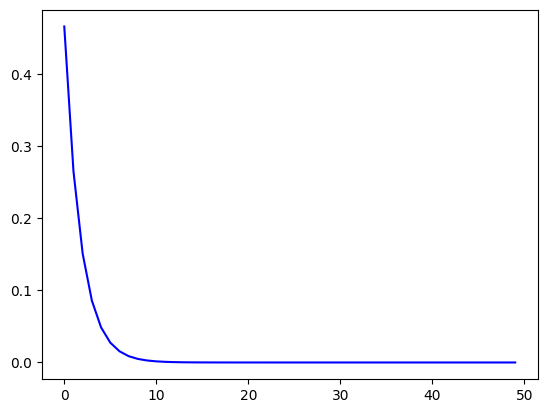

In [249]:
# Create a figure and axis object
fig, ax = plt.subplots(1, 1)

# Plot the data
ax.plot(history.history['loss'], 'blue')
ax.plot(history.history['val_loss'], 'red')

# Customize the plot
ax.set_title('Model Loss (blue) vs Val. Loss (red)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

plt.show()

In [221]:
# Extract weights from the LSTM layer
lstm_layer = model_8f.layers[0]
lstm_weights = lstm_layer.get_weights()

In [222]:
kernel, recurrent_kernel, bias = lstm_weights

# Print the shapes
print(f"Kernel shape: {kernel.shape}")
print(f"Recurrent Kernel shape: {recurrent_kernel.shape}")
print(f"Bias shape: {bias.shape}")

Kernel shape: (8, 2048)
Recurrent Kernel shape: (512, 2048)
Bias shape: (2048,)


In [223]:
# Print the weights
print("Kernel weights:", kernel)
print("Recurrent kernel weights:", recurrent_kernel)
print("Bias weights:", bias)

Kernel weights: [[ 0.05232579  0.01374082  0.01113737 ... -0.03336089  0.03715584
  -0.03538815]
 [ 0.03264289  0.02306121  0.02604442 ...  0.03129478 -0.05207984
   0.04096095]
 [-0.02632057 -0.02589257 -0.02369264 ... -0.03858705 -0.01252202
   0.00666459]
 ...
 [-0.01920575 -0.00956063  0.02410255 ...  0.01255936  0.04612235
   0.05381919]
 [ 0.04781022  0.01975601 -0.0432153  ...  0.05187599 -0.01336266
   0.03635232]
 [-0.03965205 -0.00055679 -0.03181865 ...  0.0390408  -0.0238521
   0.00138673]]
Recurrent kernel weights: [[-0.01153879 -0.00017272  0.0282393  ...  0.00996209  0.01181875
  -0.01943585]
 [ 0.01909763  0.00872338  0.02296009 ...  0.01635076  0.01008803
  -0.01466706]
 [ 0.02507331  0.0413265  -0.00896156 ...  0.01102871  0.00432566
   0.01624689]
 ...
 [-0.00220611 -0.00429316  0.03294532 ... -0.02962208  0.02178407
  -0.00670702]
 [ 0.00095747  0.00812461  0.00659628 ...  0.03368684 -0.05981153
   0.00807448]
 [ 0.00640679  0.01504548  0.01278104 ... -0.00735644 -0.

In [250]:
#  Validation Set - 06.14.2024
# ============================
# Reset Index
sample_valid = sample_valid.reset_index(drop = True)
sample_size = sample_valid.shape[0]
print ('sample_size: ', sample_size)
# sample_valid.head()
# sl = 8  # <--- sequence length
batch_valid = 2  # <--- batch size
# n_features = 8 # <---- no. of variables
# n_out = 1 # <----- no. of predicted variables
# frwd = 1  # <--- how many to predict


# Trimming Indices !!!
# Marking selected rows
sample_valid['Selected'] = 0

# Selecting m random rows without replacement
np.random.seed(125)
selected_indices = np.random.choice(sample_valid.index, size = batch_valid, replace = False)

sample_valid.loc[selected_indices, 'Selected'] = 1 # print (sample_valid[sample_valid['Selected'] == 1])
chosen_idx1 = sample_valid[sample_valid['Selected'] == 1].index
chosen_idx2 = chosen_idx1[chosen_idx1 > sl]

thrown_idx1 = chosen_idx1[chosen_idx1 <= sl]
cnt_thrown_idx1 = len(thrown_idx1)

chosen_idx3 = chosen_idx2[chosen_idx2 < (sample_size - frwd)]

thrown_idx2 = chosen_idx2[chosen_idx2 >= (sample_size - frwd)]
cnt_thrown_idx2 = len(thrown_idx2)

cnt_thrown_idx = cnt_thrown_idx1 + cnt_thrown_idx2

print (selected_indices)

all_ts_xrp = np.empty((1, )) # final input/output
all_ts_eth = np.empty((1, )) # final input/output
all_ts_ltc = np.empty((1, )) # final input/output
all_ts_btc = np.empty((1, )) # final input/output

stdev_xrp =  np.empty((1, )) # final input/output
stdev_eth =  np.empty((1, )) # final input/output
stdev_ltc =  np.empty((1, )) # final input/output
stdev_btc =  np.empty((1, )) # final input/output

aft_ts_xrp = np.empty((1))
aft_ts_eth = np.empty((1))
aft_ts_ltc = np.empty((1))
aft_ts_btc = np.empty((1))

for idx in chosen_idx3:
  selected_rows_before = sample_valid.iloc[max(0, idx-sl): idx]
  selected_rows_after = sample_valid.iloc[max(0, idx): idx+frwd]

  # print ('====================')
  sr_before_vwap_xrp = np.array(selected_rows_before['vwap_xrp'])
  sr_after_vwap_xrp = np.array(selected_rows_after['vwap_xrp'])    
  # print (sr_before_vwap_xrp)

# Compute standard deviation
  std_dev_xrp = np.std(sr_before_vwap_xrp)
  std_dev_xrp_arr = np.repeat(std_dev_xrp, sl)
  # print(std_dev_xrp_arr)

  sr_before_vwap_eth = np.array(selected_rows_before['vwap_eth'])
  sr_after_vwap_eth = np.array(selected_rows_after['vwap_eth'])

# Compute standard deviation
  std_dev_eth = np.std(sr_before_vwap_eth)
  std_dev_eth_arr = np.repeat(std_dev_eth, sl)
  # print(std_dev_eth_arr)
    

  sr_before_vwap_ltc = np.array(selected_rows_before['vwap_ltc'])
  sr_after_vwap_ltc = np.array(selected_rows_after['vwap_ltc'])

# Compute standard deviation
  std_dev_ltc = np.std(sr_before_vwap_ltc)
  std_dev_ltc_arr = np.repeat(std_dev_ltc, sl)
  # print(std_dev_ltc_arr)
    
  sr_before_vwap_btc = np.array(selected_rows_before['vwap_btc'])
  sr_after_vwap_btc = np.array(selected_rows_after['vwap_btc'])

# Compute standard deviation
  std_dev_btc = np.std(sr_before_vwap_btc)
  std_dev_btc_arr = np.repeat(std_dev_btc, sl)
  # print(std_dev_btc_arr)
    
  all_ts_xrp = np.concatenate((all_ts_xrp, sr_before_vwap_xrp))
  stdev_xrp = np.concatenate((stdev_xrp, std_dev_xrp_arr))
    
  all_ts_eth = np.concatenate((all_ts_eth, sr_before_vwap_eth))
  stdev_eth = np.concatenate((stdev_eth, std_dev_eth_arr))

  all_ts_ltc = np.concatenate((all_ts_ltc, sr_before_vwap_ltc))
  stdev_ltc = np.concatenate((stdev_ltc, std_dev_ltc_arr))

  all_ts_btc = np.concatenate((all_ts_btc, sr_before_vwap_btc))
  stdev_btc = np.concatenate((stdev_btc, std_dev_btc_arr))

  aft_ts_xrp = np.concatenate((aft_ts_xrp, sr_after_vwap_xrp))
  aft_ts_eth = np.concatenate((aft_ts_eth, sr_after_vwap_eth))
  aft_ts_ltc = np.concatenate((aft_ts_ltc, sr_after_vwap_ltc))
  aft_ts_btc = np.concatenate((aft_ts_btc, sr_after_vwap_btc))

X_XRP = all_ts_xrp[1:]
X_XRP_stdev = stdev_xrp[1:]

X_ETH = all_ts_eth[1:]
X_ETH_stdev = stdev_eth[1:]

X_LTC = all_ts_ltc[1:]
X_LTC_stdev = stdev_ltc[1:]

X_BTC = all_ts_btc[1:]
X_BTC_stdev = stdev_btc[1:]

X0_valid = np.column_stack((X_XRP, X_XRP_stdev, X_ETH, X_ETH_stdev, X_LTC, X_LTC_stdev, X_BTC, X_BTC_stdev))
print (X0_valid)

# ======== Model Input =========
X_valid = X0_valid.reshape(batch_valid-cnt_thrown_idx, sl, n_features)
print ('XXXX ====== Actual Input ====== XXXX')
print (X_valid.shape)

y_XRP = aft_ts_xrp[1:]
y_ETH = aft_ts_eth[1:]
y_LTC = aft_ts_ltc[1:]
y_BTC = aft_ts_btc[1:]

# y_valid = np.column_stack((y_XRP, y_ETH, y_LTC, y_BTC))
# print (y_valid)

y_valid = y_BTC.reshape(batch_valid-cnt_thrown_idx, frwd, n_out)
# print ('YYYY ====== Actual Input ====== YYYY')
print (y_valid.shape)

sample_size:  3340
[2459 1981]
[[4.93597160e-01 1.88567599e-04 3.68336025e-01 9.40572538e-05
  7.99405968e-01 3.40939455e-04 6.92646161e-01 8.27791498e-05]
 [4.93609641e-01 1.88567599e-04 3.68221016e-01 9.40572538e-05
  7.98633495e-01 3.40939455e-04 6.92502338e-01 8.27791498e-05]
 [4.93462410e-01 1.88567599e-04 3.68192285e-01 9.40572538e-05
  7.98732066e-01 3.40939455e-04 6.92478336e-01 8.27791498e-05]
 [4.93224118e-01 1.88567599e-04 3.68046015e-01 9.40572538e-05
  7.98648803e-01 3.40939455e-04 6.92426662e-01 8.27791498e-05]
 [4.93080436e-01 1.88567599e-04 3.67989744e-01 9.40572538e-05
  7.98699921e-01 3.40939455e-04 6.92436495e-01 8.27791498e-05]
 [4.93280821e-01 1.88567599e-04 3.68143955e-01 9.40572538e-05
  7.99042488e-01 3.40939455e-04 6.92612000e-01 8.27791498e-05]
 [4.93273371e-01 1.88567599e-04 3.68186350e-01 9.40572538e-05
  7.99276127e-01 3.40939455e-04 6.92707897e-01 8.27791498e-05]
 [4.93912719e-01 1.88567599e-04 3.67940442e-01 9.40572538e-05
  7.99959683e-01 3.40939455e-04 

In [251]:
y_hat = model_8f.predict(X_valid, verbose = 1).reshape(batch_valid-cnt_thrown_idx, frwd)
# print (sl)

print ('y_valid')
print (type(y_valid))
print (y_valid.shape)
print (y_valid)
# print (y_valid[0:10])

print ('y_hat')
print (type(y_hat))
print (y_hat.shape)
print (y_hat)
# y_ht1 = y_hat.reshape(batch-cnt_thrown_idx, frwd)
# # print (y_hat[0:10])
# print (y_ht1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step
y_valid
<class 'numpy.ndarray'>
(2, 1, 1)
[[[0.69274031]]

 [[0.69615353]]]
y_hat
<class 'numpy.ndarray'>
(2, 1)
[[0.6757623]
 [0.6760601]]




0


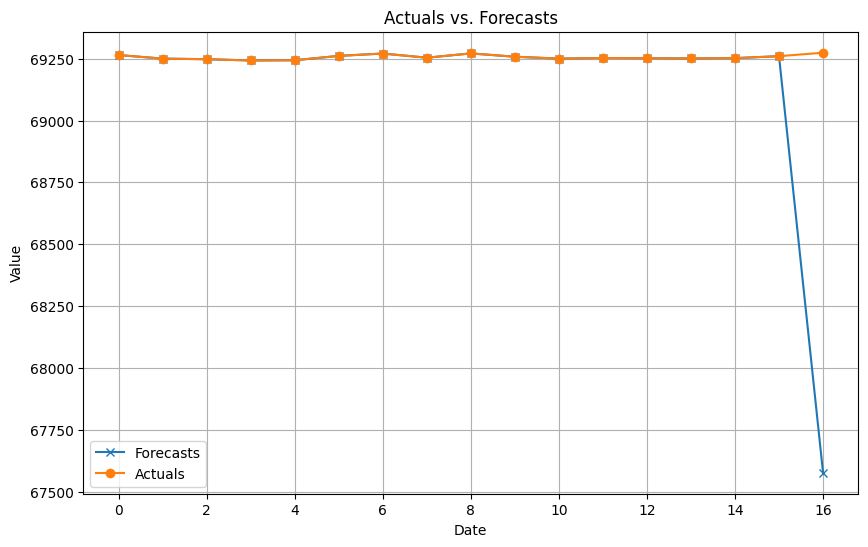



1


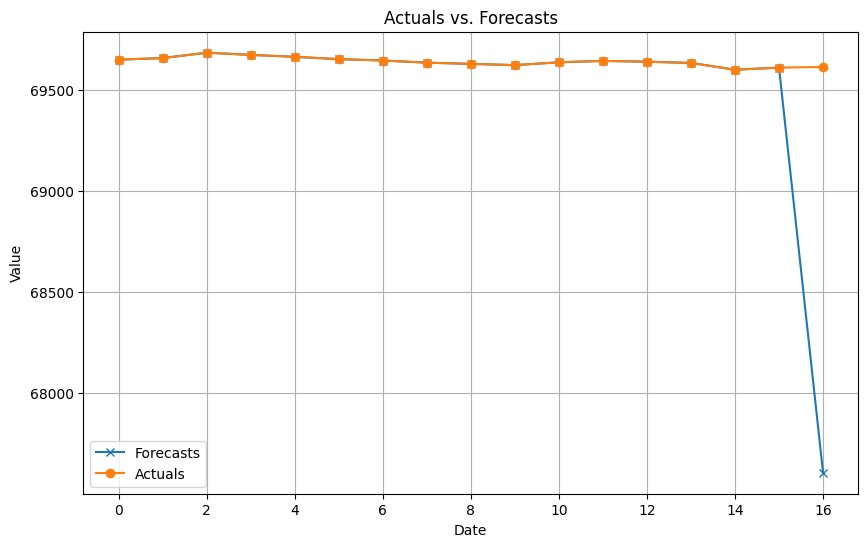

In [252]:
for i in range(batch_valid-cnt_thrown_idx):
    print ('\n')  
    print (i)
    X_resh = X_valid[i:i+1, :, 6].flatten()
    # print (X_resh)
    # print ('\n')
    y_resh = y_valid[i:i+1].flatten()
    # print (y_resh)
    y_est_resh = y_hat[i:i+1].flatten()
    # print (y_est_resh)
    # print ('\n')
    actual = np.concatenate((X_resh, y_resh)) * 100000.00
    # print (actual)
    # print ('\n')
    estimate = np.concatenate((X_resh, y_est_resh)) * 100000.00
    # print (estimate)

    dates = list(range(sl+frwd))
    
    # Create a pandas DataFrame
    data = pd.DataFrame({'Date': dates, 'Actuals': actual, 'Forecasts': estimate})
    
    # Set the 'Date' column as the index
    data.set_index('Date', inplace=True)
    
    # Create a figure and axis object using object-oriented style
    fig, ax = plt.subplots(figsize = (10, 6))
    
    # Plot actuals vs. forecasts
    ax.plot(data.index, data['Forecasts'], label = 'Forecasts', marker = 'x')
    ax.plot(data.index, data['Actuals'], label = 'Actuals', marker = 'o')
    
    # Set labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.set_title('Actuals vs. Forecasts')

    ax.legend() # Add legend

    ax.grid(True) # Add grid
    
    plt.show()

In [255]:
print (sample_test.head(1))

    date  close_xrp    volume_xrp  vwap_xrp  close_eth  volume_eth  vwap_eth  \
0  1-0-0     0.5173  28809.165339  0.517217   0.376204   37.497964  0.376108   

   close_ltc  volume_ltc  vwap_ltc  close_btc  volume_btc  vwap_btc  Selected  
0     0.8317  110.056253  0.831662    0.67506    2.045049  0.674969         0  


In [1]:
# variables are volume and volume
# ==============================
#  Test Sample --- 06.14.2024
# ==============================
sample_size = sample_test.shape[0]
print ('sample_size: ', sample_size)

sl = 16  # <--- sequence length
batch = 1  # <--- batch size
n_features = 8 # <---- no. of variables
n_out = 1 # <----- no. of predicted variables
frwd = 1  # <--- how many to predict


# Trimming Indices !!!
# Marking selected rows
sample_test['Selected'] = 0

# Selecting m random rows without replacement
np.random.seed(125)
selected_indices = np.random.choice(sample_test.index, size = batch, replace = False)

sample_test.loc[selected_indices, 'Selected'] = 1 # print (sample_test[sample_test['Selected'] == 1])
chosen_idx1 = sample_test[sample_test['Selected'] == 1].index
chosen_idx2 = chosen_idx1[chosen_idx1 > sl]

thrown_idx1 = chosen_idx1[chosen_idx1 <= sl]
cnt_thrown_idx1 = len(thrown_idx1)

chosen_idx3 = chosen_idx2[chosen_idx2 < (sample_size - frwd)]

thrown_idx2 = chosen_idx2[chosen_idx2 >= (sample_size - frwd)]
cnt_thrown_idx2 = len(thrown_idx2)

cnt_thrown_idx = cnt_thrown_idx1 + cnt_thrown_idx2

print (selected_indices)

# all_ts_xrp = np.empty((1, )) # final input/output
# all_ts_eth = np.empty((1, )) # final input/output
# all_ts_ltc = np.empty((1, )) # final input/output
# all_ts_btc = np.empty((1, )) # final input/output


all_ts_close_xrp = np.empty((1, )) # final input/output
all_ts_close_eth = np.empty((1, )) # final input/output
all_ts_close_ltc = np.empty((1, )) # final input/output
all_ts_close_btc = np.empty((1, )) # final input/output

all_ts_volume_xrp = np.empty((1, )) # final input/output
all_ts_volume_eth = np.empty((1, )) # final input/output
all_ts_volume_ltc = np.empty((1, )) # final input/output
all_ts_volume_btc = np.empty((1, )) # final input/output

stdev_xrp =  np.empty((1, )) # final input/output
stdev_eth =  np.empty((1, )) # final input/output
stdev_ltc =  np.empty((1, )) # final input/output
stdev_btc =  np.empty((1, )) # final input/output


aft_ts_xrp = np.empty((1))
aft_ts_eth = np.empty((1))
aft_ts_ltc = np.empty((1))
aft_ts_btc = np.empty((1))

for idx in chosen_idx3:
  selected_rows_before = sample_test.iloc[max(0, idx-sl): idx]
  selected_rows_after = sample_test.iloc[max(0, idx): idx+frwd]

  # xrp
  sr_before_close_xrp = np.array(selected_rows_before['close_xrp'])
  sr_after_close_xrp = np.array(selected_rows_after['close_xrp'])    
  # print (sr_before_close_xrp)
  sr_before_volume_xrp = np.array(selected_rows_before['volume_xrp'])
  sr_after_volume_xrp = np.array(selected_rows_after['volume_xrp'])    
  # print (sr_before_volume_xrp)  
    # Compute standard deviation
  std_dev_xrp = np.std(sr_before_close_xrp)
  std_dev_xrp_arr = np.repeat(std_dev_xrp, sl)
  # print(std_dev_xrp_arr)
    
# eth
  sr_before_close_eth = np.array(selected_rows_before['close_eth'])
  sr_after_close_eth = np.array(selected_rows_after['close_eth'])
  sr_before_volume_eth = np.array(selected_rows_before['volume_eth'])
  sr_after_volume_eth = np.array(selected_rows_after['volume_eth'])
    # Compute standard deviation
  std_dev_eth = np.std(sr_before_close_eth)
  std_dev_eth_arr = np.repeat(std_dev_eth, sl)
  # print(std_dev_eth_arr)
    
# ltc
  sr_before_close_ltc = np.array(selected_rows_before['close_ltc'])
  sr_after_close_ltc = np.array(selected_rows_after['close_ltc'])
  sr_before_volume_ltc = np.array(selected_rows_before['volume_ltc'])
  sr_after_volume_ltc = np.array(selected_rows_after['volume_ltc'])
# Compute standard deviation
  std_dev_ltc = np.std(sr_before_close_ltc)
  std_dev_ltc_arr = np.repeat(std_dev_ltc, sl)
  # print(std_dev_ltc_arr)

# btc
  sr_before_close_btc = np.array(selected_rows_before['close_btc'])
  sr_after_close_btc = np.array(selected_rows_after['close_btc'])
  sr_before_volume_btc = np.array(selected_rows_before['volume_btc'])
  sr_after_volume_btc = np.array(selected_rows_after['volume_btc'])
    # Compute standard deviation
  std_dev_btc = np.std(sr_before_close_btc)
  std_dev_btc_arr = np.repeat(std_dev_btc, sl)
  # print(std_dev_btc_arr)

# xrp
  all_ts_close_xrp = np.concatenate((all_ts_close_xrp, sr_before_close_xrp))
  all_ts_volume_xrp = np.concatenate((all_ts_volume_xrp, sr_before_volume_xrp))
  stdev_xrp = np.concatenate((stdev_xrp, std_dev_xrp_arr))
# eth
  all_ts_close_eth = np.concatenate((all_ts_close_eth, sr_before_close_eth))
  all_ts_volume_eth = np.concatenate((all_ts_volume_eth, sr_before_volume_eth))
  stdev_eth = np.concatenate((stdev_eth, std_dev_eth_arr))
# ltc
  all_ts_close_ltc = np.concatenate((all_ts_close_ltc, sr_before_close_ltc))
  all_ts_volume_ltc = np.concatenate((all_ts_volume_ltc, sr_before_volume_tc))
  stdev_ltc = np.concatenate((stdev_ltc, std_dev_ltc_arr))
# btc
  all_ts_close_btc = np.concatenate((all_ts_close_btc, sr_before_close_btc))
  all_ts_volume_btc = np.concatenate((all_ts_volume_btc, sr_before_volume_btc))
  stdev_btc = np.concatenate((stdev_btc, std_dev_btc_arr))


  aft_ts_close_xrp = np.concatenate((aft_ts_close_xrp, sr_after_close_xrp))
  aft_ts_close_eth = np.concatenate((aft_ts_close_eth, sr_after_close_eth))
  aft_ts_close_ltc = np.concatenate((aft_ts_close_ltc, sr_after_close_ltc))
  aft_ts_close_btc = np.concatenate((aft_ts_close_btc, sr_after_close_btc))


X_XRP_close = all_ts_close_xrp[1:]
X_XRP_volume = all_ts_volume_xrp[1:]
X_XRP_stdev = stdev_xrp[1:]


X_ETH_close = all_ts_close_eth[1:]
X_ETH_volume = all_ts_volume_eth[1:]
X_ETH_stdev = stdev_eth[1:]

X_LTC_close = all_ts_close_ltc[1:]
X_LTC_volume = all_ts_volume_ltc[1:]
X_LTC_stdev = stdev_ltc[1:]

X_BTC_close = all_ts_close_btc[1:]
X_BTC_volume = all_ts_volume_btc[1:]
X_BTC_stdev = stdev_btc[1:]

X0 = np.column_stack((X_XRP_close, X_XRP_volume, 
                      X_ETH_close, X_ETH_volume, 
                      X_LTC_close, X_LTC_volume, 
                      X_BTC_close, X_BTC_volume))
print (X0)

# ======== Model Input =========
X = X0.reshape(batch-cnt_thrown_idx, sl, n_features)
print ('XXXX ====== Actual Input ====== XXXX')
print (X.shape)

y_XRP = aft_ts_xrp[1:]
y_ETH = aft_ts_eth[1:]
y_LTC = aft_ts_ltc[1:]
y_BTC = aft_ts_btc[1:]

y = np.column_stack((y_XRP, y_ETH, y_LTC, y_BTC))
print (y)

y = y_BTC.reshape(batch-cnt_thrown_idx, frwd, n_out)
# print ('YYYY ====== Actual Input ====== YYYY')
print (y.shape)

NameError: name 'sample_test' is not defined